# ICA on Synaptic Inputs

This analysis focuses on applying Independent Component Analysis (ICA) to a segment of Local Field Potential (LFP) data and evaluating its components for synaptic activity and artifact removal.

## Steps

### 1. Load LFP Segment
- **Data Description**: Load a segment of LFP data consisting of 16 channels, with a duration of 50–100 seconds.
- **Objective**: Use this segment as the input for ICA decomposition.
- **Pythonic Hint**: Use `numpy` or `pandas` to load and handle your LFP data. If the data is in a specific file format like `.mat` or `.edf`, consider libraries such as `scipy.io` or `mne`.

---

### 2. Apply ICA Decomposition
- **Method**: Apply ICA decomposition using the FastICA algorithm to the raw LFP data.
  - **Data Structure**: Treat each channel as a feature (dimension) and each time point as a sample. Ensure the input data matrix is organized as 
    $$
    X \in \mathbb{R}^{T \times C},
    $$
    where \( T \) is the number of time points and \( C \) is the number of channels.
  - **Pythonic Hint**:
    ```python
    from sklearn.decomposition import FastICA
    
    # Assuming `lfp_data` is your input matrix with shape (T, C)
    ica = FastICA(n_components=C, random_state=42)
    S = ica.fit_transform(lfp_data)  # Independent components (sources)
    A = ica.mixing_  # Mixing matrix (spatial loadings)
    ```

---

### 3. Analyze ICA Components

#### a. Spatial Profiles of IC Loadings
1. **Matrix \( A \)**:
   - Extract the spatial loadings matrix \( A \) (mixing matrix) from the ICA decomposition.
   - **Plot**: Visualize the spatial profile of the columns of \( A \).
   - **Pythonic Hint**:
     ```python
     import matplotlib.pyplot as plt
     plt.plot(A)
     plt.title("Spatial Profiles of ICA Loadings")
     plt.xlabel("Channels")
     plt.ylabel("Loadings")
     plt.show()
     ```

2. **Current Source Density (CSD)**:
   - Compute the CSD for each column \( A_k(x) \), using the formula:
     $$
     \text{CSD}_k(x) = -\frac{d^2 A_k(x)}{dx^2}.
     $$
   - **Pythonic Hint**:
     ```python
     import numpy as np
     # Numerical second derivative using finite differences
     CSD = -np.diff(A, n=2, axis=0)  # Apply along spatial dimension
     plt.plot(CSD)
     plt.title("Current Source Density (CSD)")
     plt.xlabel("Channels")
     plt.ylabel("CSD")
     plt.show()
     ```

3. **Component Activations**:
   - Extract the activation time series \( s \) for the first \( K \) components.
   - **Plot**: Time series of activations for these components.
   - **Pythonic Hint**:
     ```python
     for k in range(K):
         plt.plot(S[:, k], label=f"Component {k+1}")
     plt.title("Activations for the First K Components")
     plt.xlabel("Time Points")
     plt.ylabel("Activation")
     plt.legend()
     plt.show()
     ```

4. **Power Spectra**:
   - Compute the power spectra of the activations in:
     - **Theta Range**: \( 4 \, \text{Hz} \leq f \leq 8 \, \text{Hz} \)
     - **Gamma Range**: \( 30 \, \text{Hz} \leq f \leq 100 \, \text{Hz} \)
   - **Pythonic Hint**:
     ```python
     from scipy.signal import welch
     fs = 1000  # Sampling frequency (example: 1000 Hz)
     for k in range(K):
         f, Pxx = welch(S[:, k], fs=fs, nperseg=1024)
         plt.semilogy(f, Pxx, label=f"Component {k+1}")
     plt.xlim([0, 100])  # Adjust range to show theta and gamma
     plt.title("Power Spectra of Activations")
     plt.xlabel("Frequency (Hz)")
     plt.ylabel("Power Spectral Density")
     plt.legend()
     plt.show()
     ```

---

#### b. Identify and Remove EMG Artifacts
1. **Identify EMG Components**:
   - Look for components with:
     - A high-frequency spectral peak (\( > 200 \, \text{Hz} \)).
     - Uniform spatial loadings across channels.
   - **Pythonic Hint**:
     ```python
     # Identify EMG components
     emg_components = [k for k in range(C) if max(f[k] > 200) and np.std(A[:, k]) < threshold]
     ```

2. **Remove EMG Components**:
   - Exclude the identified EMG components from the signal.
   - **Pythonic Hint**:
     ```python
     # Reconstruct the signal without EMG components
     cleaned_S = S.copy()
     cleaned_S[:, emg_components] = 0
     cleaned_signal = np.dot(cleaned_S, A.T)
     ```

3. **Compare Spectra Before and After**:
   - Select one channel of LFP data.
   - Compute and compare its power spectra before and after removing the EMG component.
   - **Pythonic Hint**:
     ```python
     # Power spectra comparison
     f_orig, Pxx_orig = welch(lfp_data[:, selected_channel], fs=fs, nperseg=1024)
     f_clean, Pxx_clean = welch(cleaned_signal[:, selected_channel], fs=fs, nperseg=1024)
     
     plt.semilogy(f_orig, Pxx_orig, label="Original")
     plt.semilogy(f_clean, Pxx_clean, label="Cleaned")
     plt.title("Power Spectra Before and After EMG Removal")
     plt.xlabel("Frequency (Hz)")
     plt.ylabel("Power Spectral Density")
     plt.legend()
     plt.show()
     ```

---

### Suggested Libraries
- **Data Handling**: `numpy`, `pandas`
- **Signal Processing**: `scipy`, `mne`, `matplotlib`
- **ICA**: `scikit-learn`

# Exercise 0

In [1]:
from sklearn.decomposition import FastICA
import numpy as np
import matplotlib.pyplot as plt

In [2]:
Rot_matrix = lambda theta: np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
def gaussian_cluster(mean, theta, cov_diag, size):
    R = Rot_matrix(theta)
    cov = R @ np.diag(cov_diag) @ R.T
    return np.random.multivariate_normal(mean, cov, size=size)

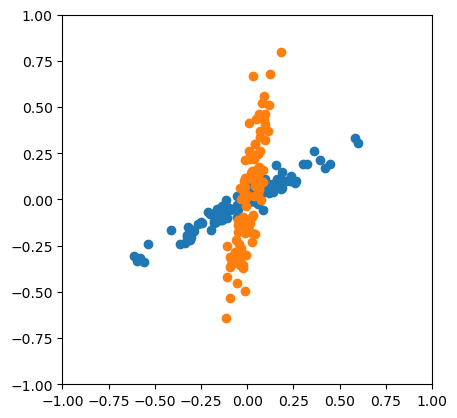

In [3]:
N = 100
dtheta = 50/180 *np.pi
d1 = gaussian_cluster(mean=(0,0), theta=np.pi/6, cov_diag=[0.1, 0.001], size=N)
d2 = gaussian_cluster(mean=(0,0), theta=np.pi/6 + dtheta, cov_diag=[0.1, 0.001], size=N)

fig, ax = plt.subplots(1,1)
ax.scatter(d1[:,0], d1[:, 1])
ax.scatter(d2[:,0], d2[:, 1])
d_tot = np.concatenate((d1,d2))
ax.set(aspect='equal', xlim=[-1, 1], ylim=[-1, 1])
plt.show()

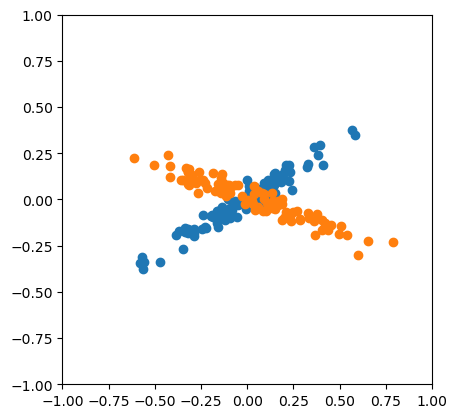

In [4]:
# pca
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(d_tot)
d_pca = pca.transform(d_tot)

fig, ax = plt.subplots(1,1)
ax.scatter(d_pca[:N,0], d_pca[:N, 1])
ax.scatter(d_pca[N:,0], d_pca[N:, 1])
ax.set(aspect='equal', xlim=[-1, 1], ylim=[-1, 1])
plt.show()

In [14]:
n_components = 1
ica = FastICA(n_components, whiten='unit-variance')
_sources = ica.fit_transform(d_tot)
_d_reconstruct = ica.inverse_transform(_sources, copy=True)
# ica.components_ = ica._unmixing @ ica.whitening_ = np.linalg.inv(ica.mixing_)
_sources.shape

(200, 1)

In [17]:
ica.components_ @ ica.mixing_

array([[1.]])

In [16]:
ica.mixing_ @ ica.components_

array([[0.24539772, 0.43032276],
       [0.43032276, 0.75460228]])

In [13]:
# x_tot @ ica.components_ @ ica.mixing_ = _sources @ ica.mixing_

# ica.components_ @ ica.mixing_ = 1

NameError: name 'x_tot' is not defined

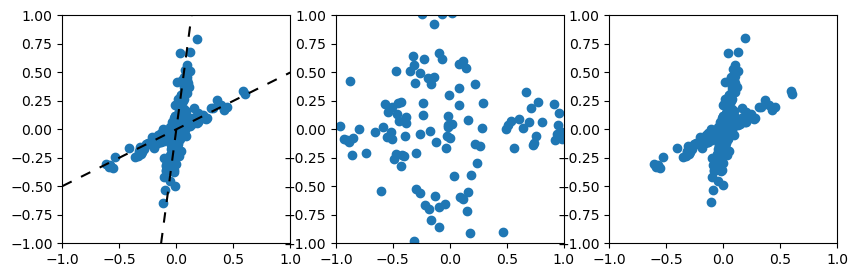

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,5))
ax[0].scatter(d_tot[:,0], d_tot[:, 1])
ax[0].set(aspect='equal', xlim=[-1, 1], ylim=[-1, 1])
for i in range(n_components):
    ax[0].axline((0, 0), slope=ica.components_[1, i]/ica.components_[0, i], color="black", linestyle=(0, (5, 5)))

ax[1].scatter(_sources[:,0], _sources[:, 1])
ax[1].set(aspect='equal', xlim=[-1, 1], ylim=[-1, 1])

d_tot_reconstruct = _sources @ ica.mixing_.T
ax[2].scatter(d_tot_reconstruct[:,0], d_tot_reconstruct[:, 1])
ax[2].set(aspect='equal', xlim=[-1, 1], ylim=[-1, 1])

plt.show()

In [44]:
ica

FastICA(n_components=16)

# Exercise 1

# 1. Load the data

In [24]:
from scipy.stats import zscore
from scipy import io
from scipy import signal

In [25]:
lfps = io.loadmat('../data/ws_data_1shank.mat')['lfps'].astype(np.int32) # array of LFP data
lfps = zscore(lfps, axis=None)
lfps_std = np.std(lfps, axis=None)
fs = 1250 # sampling frequency
dt = 1/fs
T = 100
N_total = T * fs
time_vec = np.arange(N_total)*dt

In [49]:
n_components = 16
ica = FastICA(n_components=n_components, whiten='unit-variance')
_s = ica.fit_transform(lfps)
# ica.components_ = ica._unmixing @ ica.whitening_ = np.linalg.inv(ica.mixing_)

In [50]:
ica.mixing_.shape

(16, 16)

In [27]:
# lfps = _s @ ica.mixing_.T
# LFP(x) = s(x,t)a(x)
# lfps[sample, ch] = _s[sample, icomp] ica.mixing_.T[icomp]
# a[ch] = ica.mixing_.T[ch]
A = ica.mixing_ # A[ich, icomp]
b, a = signal.butter(2, 0.2, btype='lowpass', fs=1)
A_smooth = signal.filtfilt(b, a, A, axis=0)
CSD_A = -np.diff(A_smooth, axis=0, n=2)
CSD = CSD_A @ _s.T

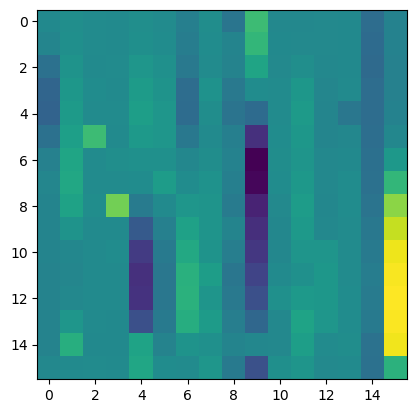

In [28]:
plt.imshow(A)

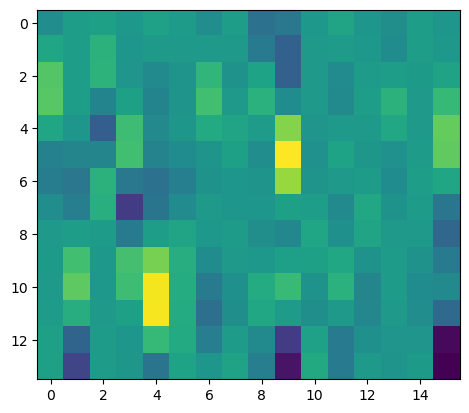

In [29]:
fig = plt.figure
im = plt.imshow(np.diff(A_smooth, axis=0, n=2))

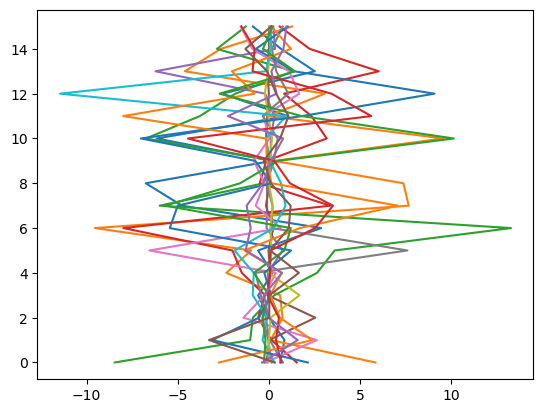

In [30]:
fig, ax = plt.subplots(1,1)
selection = np.arange(n_components)
# selection = [2, 6]
ax.plot(ica.components_[:, selection], np.arange(16))
plt.show()

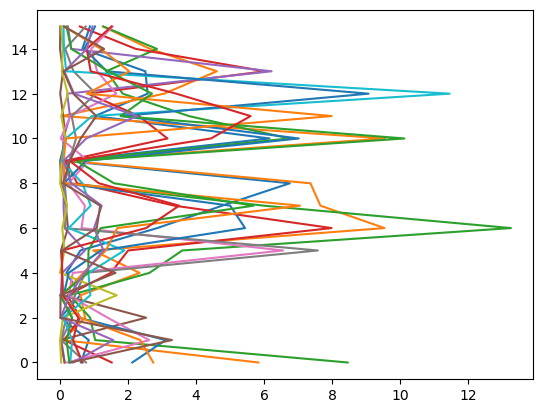

In [31]:
fig, ax = plt.subplots(1,1)
selection = np.arange(16)
# selection = [2, 6]
ax.plot(np.abs(ica.components_[:, selection]), np.arange(16))
plt.show()

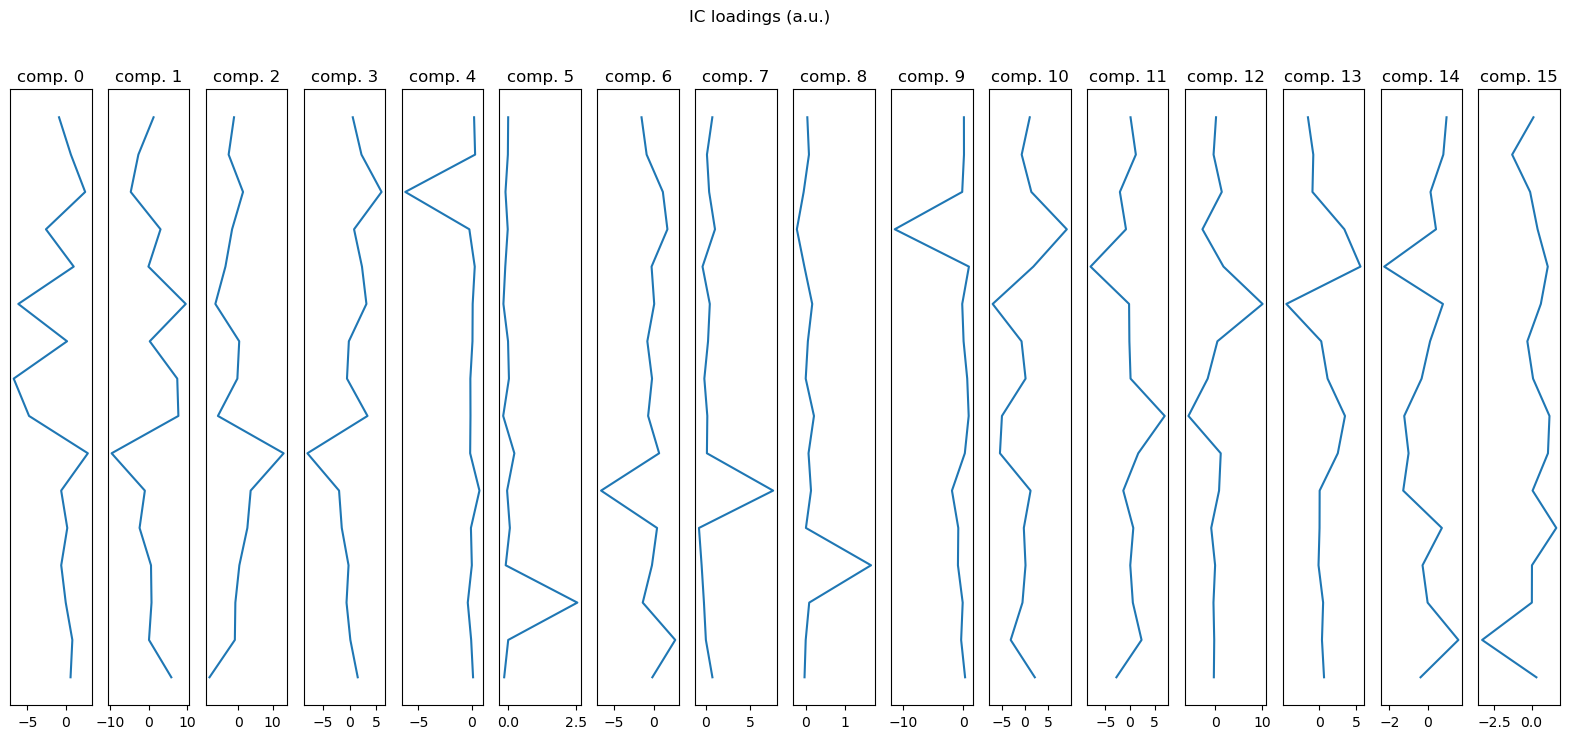

In [36]:
from matplotlib import gridspec
# selection = np.arange(16)
fig = plt.figure(figsize=(20,8))
gs = gridspec.GridSpec(1,n_components, figure=fig)
for icomp in range(n_components):
    ax = fig.add_subplot(gs[icomp])
    if i>0:
        ax.set(yticks=[])
    else:
        ax.set(ylabel='channels')
    ax.plot(ica.components_[:, icomp], np.arange(16))
    ax.set(title='comp. %d'%icomp)

fig.suptitle('IC loadings (a.u.)')
plt.show()

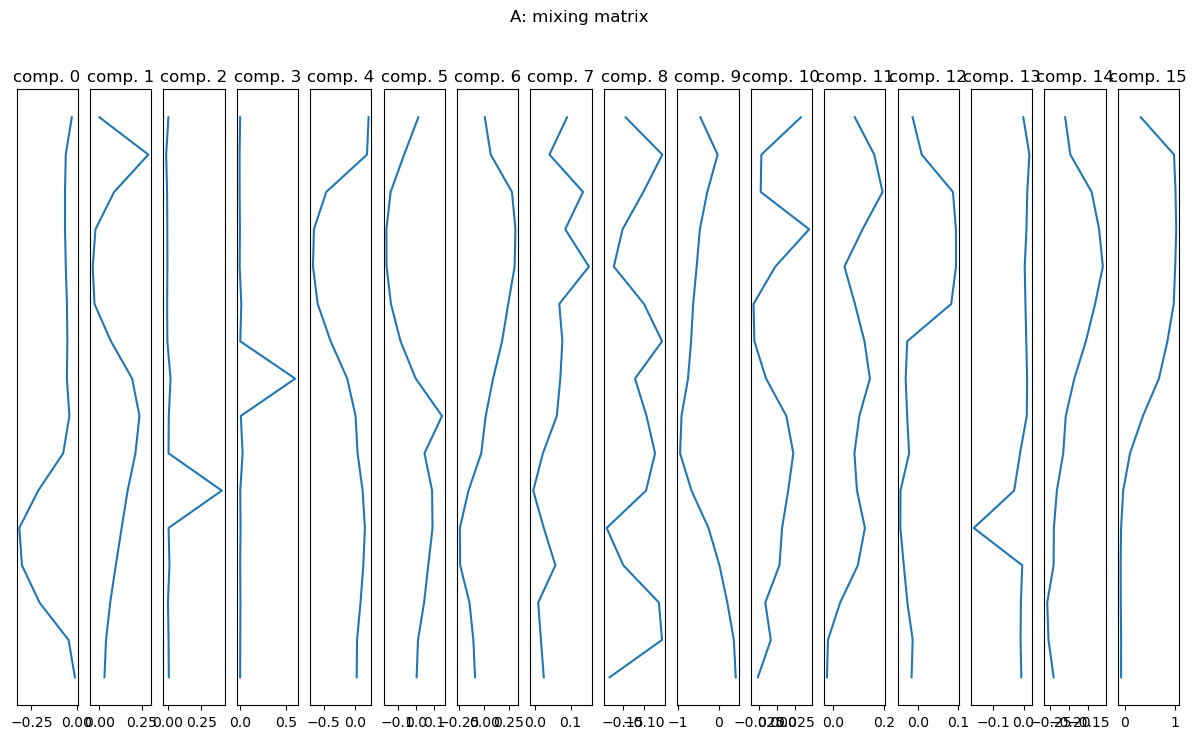

In [ ]:
# selection = np.arange(16)
fig = plt.figure(figsize=(15,8))
gs = gridspec.GridSpec(1,16, figure=fig)
for icomp in range(n_components):
    ax = fig.add_subplot(gs[icomp])
    if i>0:
        ax.set(yticks=[])
    ax.plot(A[:,icomp], np.arange(16))
    ax.set(title='comp. %d'%icomp)
    # ax.set(xlim=[-0.025, 0.025], xticks=[-0.02, 0, 0.02], xticklabels=[-1,0,1], title='comp. %d'%icomp)

fig.suptitle('A: mixing matrix')
plt.show()

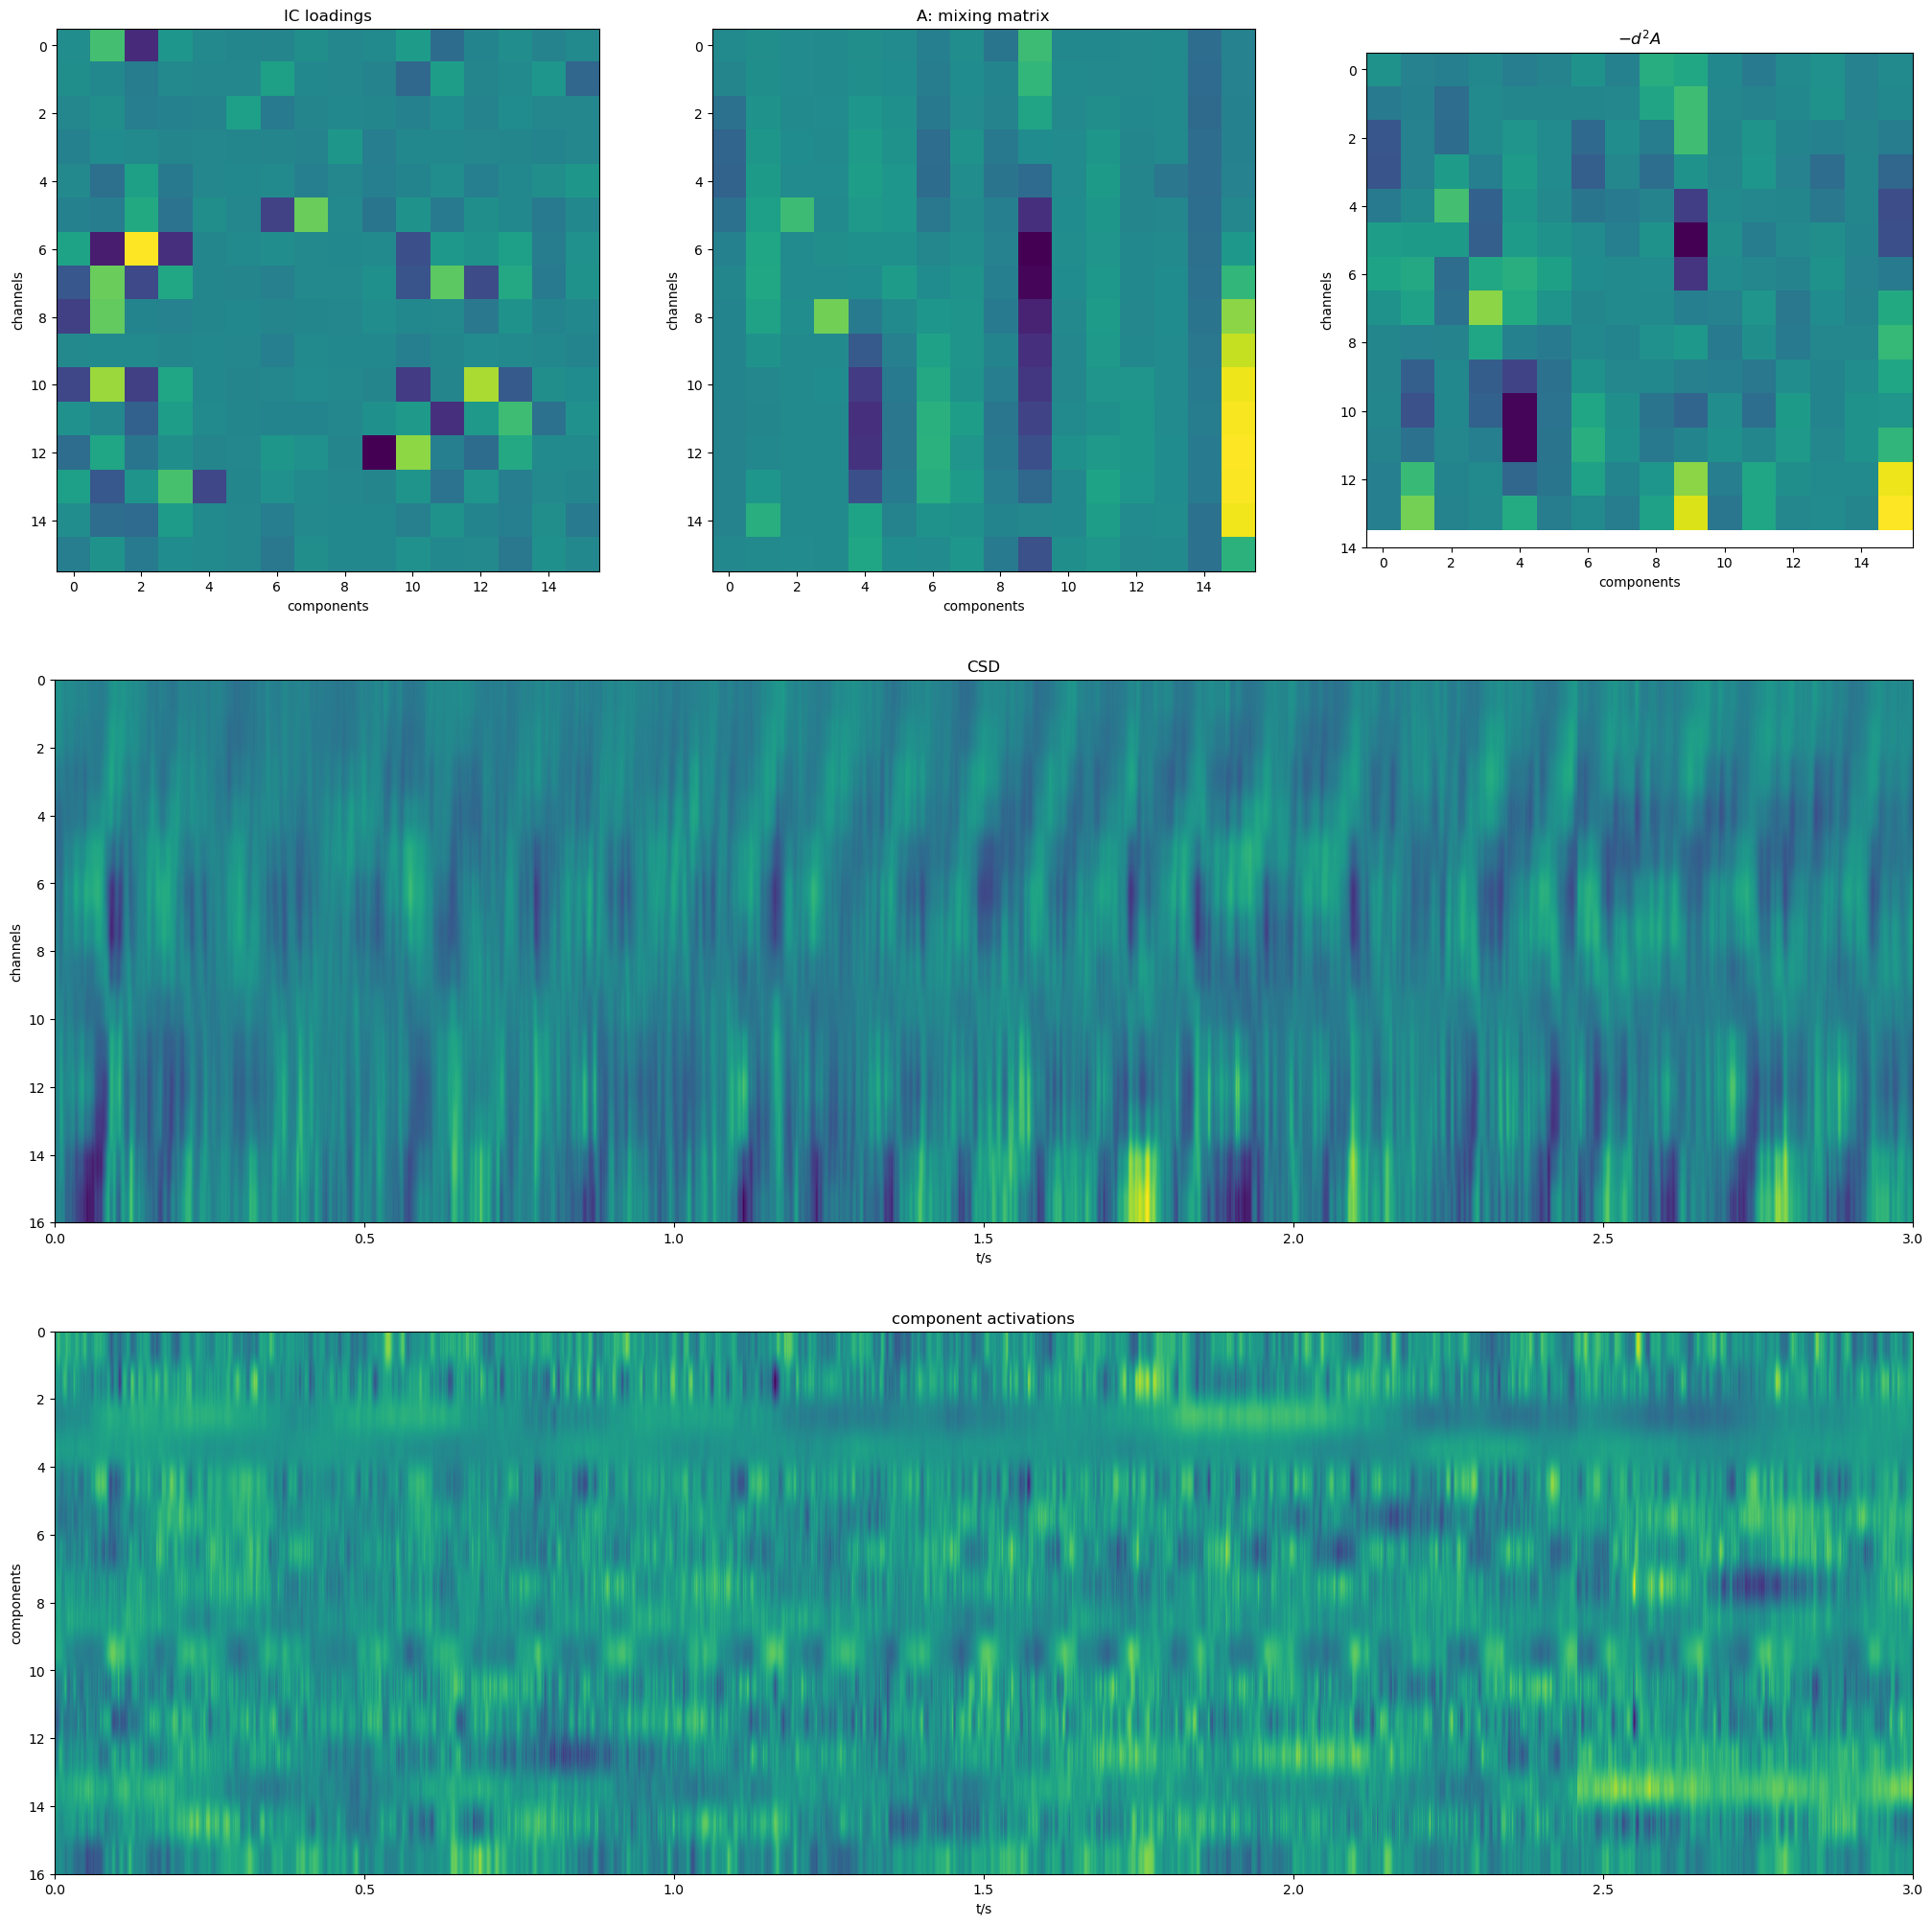

In [38]:
fig = plt.figure(figsize=(25,25))
gs = gridspec.GridSpec(3,3, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
ax0.imshow(ica.components_)
ax0.set(xlabel='components', ylabel='channels', yticks=np.arange(16)[::2], xticks=np.arange(n_components)[::2], title='IC loadings')

ax1 = fig.add_subplot(gs[0, 1])
ax1.imshow(A)
ax1.set(xlabel='components', ylabel='channels', yticks=np.arange(16)[::2], xticks=np.arange(n_components)[::2], title='A: mixing matrix')

ax2 = fig.add_subplot(gs[0, 2])
ax2.imshow(CSD_A)
ax2.set(xlabel='components', ylabel='channels', yticks=np.arange(15)[::2], xticks=np.arange(n_components)[::2], title='$-d^2 A$')

ax3 = fig.add_subplot(gs[1, :])
ax3.imshow(CSD[:, :fs*3], aspect='auto', extent=[0, 3, n_components, 0])
ax3.set(xlabel='t/s', ylabel='channels', title='CSD')

ax4 = fig.add_subplot(gs[2, :])
ax4.imshow(_s.T[:, :fs*3], aspect='auto', extent=[0, 3, n_components, 0])
ax4.set(xlabel='t/s', ylabel='components', title='component activations')
plt.show()